In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import StratifiedKFold, cross_val_score

In [2]:

embeddings_df = pd.read_csv("out/embeddings_processed.csv")
structured_df = pd.read_csv("out/data.csv")

embeddings_df = embeddings_df['embedding'].str.split(',', expand=True)

# convert all columns to float
embeddings_df = embeddings_df.astype(float)

# rename columns like 'emb_0', 'emb_1', ...
embeddings_df.columns = [f'emb_{i}' for i in range(embeddings_df.shape[1])]

data = pd.concat([embeddings_df, structured_df], axis=1)

data = data.drop(columns=["cases.submitter_id"])

# Step 3: Initial exploration
print("Initial data shape:", data.shape)
print(data.head())
print(data.info())
print(data['OS'].value_counts())

print(data.shape)


Initial data shape: (658, 788)
      emb_0     emb_1     emb_2     emb_3     emb_4     emb_5     emb_6  \
0 -0.372847  1.175885 -0.136382  0.584974 -0.075458  0.242736 -0.091984   
1 -0.356913  0.706686  0.037918  0.460797 -0.655461 -0.034329 -0.260771   
2 -0.650745  0.622192 -0.541576 -0.147439 -0.688726  0.005337  0.160113   
3 -0.243454  0.907251 -0.278341  0.578471 -0.371568  0.370125 -0.096557   
4 -0.501727  0.816661 -0.331489  0.102610 -0.754066  0.199273  0.021237   

      emb_7     emb_8     emb_9  ...  diagnoses.laterality  \
0  0.850612  1.272928 -0.353911  ...                  Left   
1  0.986547  1.546444 -0.446621  ...                 Right   
2  0.956877  0.844839 -0.026274  ...                 Right   
3  0.984593  1.147140 -0.293077  ...                 Right   
4  0.814512  1.281691 -0.193750  ...                 Right   

   diagnoses.morphology  diagnoses.prior_malignancy  \
0                8140/3                         yes   
1                8140/3            

In [3]:
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].astype(str)

In [4]:
num_cols = data.select_dtypes(include=[np.number]).columns
cat_cols = data.select_dtypes(include=['object']).columns

In [5]:
num_imputer = SimpleImputer(strategy='median')
for col in num_cols:
    if pd.api.types.is_numeric_dtype(data[col]):
        data[col] = data[col].astype(float)
        data[col] = num_imputer.fit_transform(data[[col]])

In [6]:
if len(cat_cols) > 0:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    data[cat_cols] = pd.DataFrame(
        cat_imputer.fit_transform(data[cat_cols]),
        columns=cat_cols,
        index=data.index
    )


In [7]:
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    le_dict[col] = le


In [8]:
# # Assuming X and embedding_cols are defined from Cell 21

# # --- 1. Isolate and Scale the Embedding Features ---
# X_embeddings = X[embedding_cols]

# scaler = StandardScaler()
# X_embeddings_scaled = scaler.fit_transform(X_embeddings)

# # --- 2. Perform PCA with all components to find explained variance ---
# # n_components=None tells PCA to keep all components
# pca_variance = PCA(n_components=None)
# pca_variance.fit(X_embeddings_scaled)

# # --- 3. Calculate Cumulative Explained Variance ---
# cumulative_variance = np.cumsum(pca_variance.explained_variance_ratio_)

# # --- 4. Find the Optimal Number of Components (e.g., for 90% variance) ---
# # The result will be the index + 1
# components_90 = np.argmax(cumulative_variance >= 0.90) + 1

# # --- 5. Plot the Cumulative Explained Variance (Scree Plot) ---
# plt.figure(figsize=(10, 6))
# plt.plot(cumulative_variance, marker='o', linestyle='--', color='blue', label='Cumulative Explained Variance')
# plt.title('PCA Cumulative Explained Variance vs. Number of Components')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance Ratio')
# plt.grid(True)

# # Highlight the 90% threshold
# plt.axhline(y=0.90, color='red', linestyle='-', label='90% Threshold')
# plt.axvline(x=components_90 - 1, color='green', linestyle='-', 
#             label=f'90% Variance at {components_90} Components')

# plt.legend()
# plt.show() # Display the plot in the notebook

# print(f"\nRecommended n_components to capture 90% variance: {components_90}")

In [9]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- Feature Groups (must be defined from your earlier cells) ---
# Assuming these are defined globally:
# embedding_cols = [col for col in X.columns if col.startswith('emb_')]
# data_cols = [col for col in X.columns if not col.startswith('emb_')]
# X and y

# 1. Define the Range of PCA Components to Test
pca_n_components_range = [5, 10, 15, 20, 25, 30, 44] 
best_auc = 0
best_n = 0

print("--- Tuning PCA Components (Combined Data) ---")

# 2. Loop through each component count
for n in pca_n_components_range:
    # --- Define Pipelines for this 'n' ---
    pca_pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),
        # PCA is updated in each loop
        ('pca', PCA(n_components=n))
    ])

    structured_pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),
    ])

    # --- Create the ColumnTransformer for this 'n' ---
    preprocessor = ColumnTransformer(
        transformers=[
            ('pca_transform', pca_pipeline, embedding_cols),
            ('structured_scale', structured_pipeline, data_cols)
        ],
        remainder='drop',
        n_jobs=-1
    )
    
    # 3. Apply the Transformation
    X_current_n = preprocessor.fit_transform(X)

    # 4. Run Stratified Cross-Validation
    model = RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        class_weight='balanced', 
        n_jobs=-1
    )
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scoring = 'roc_auc'

    cv_scores = cross_val_score(
        estimator=model, 
        X=X_current_n, 
        y=y, 
        cv=skf,             
        scoring=scoring,    
        n_jobs=-1           
    )
    
    mean_auc = cv_scores.mean()
    print(f"N={n} Components -> Mean ROC AUC: {mean_auc:.4f}")

    if mean_auc > best_auc:
        best_auc = mean_auc
        best_n = n

print(f"\n--- Result ---")
print(f"Optimal PCA Components (N): {best_n}")
print(f"Best Mean ROC AUC: {best_auc:.4f}")

--- Tuning PCA Components (Combined Data) ---


NameError: name 'embedding_cols' is not defined

In [ ]:
X = data.drop('OS', axis=1)
y = data['OS']

# --- 1. Identify feature groups ---
# All columns starting with 'emb_' are embedding features
embedding_cols = [col for col in X.columns if col.startswith('emb_')]
# All other columns are structured data features (now label-encoded and imputed)
data_cols = [col for col in X.columns if not col.startswith('emb_')]

print(f"Number of embedding features: {len(embedding_cols)}")
print(f"Number of structured data features: {len(data_cols)}")

# --- 2. Define Pipelines ---

# Pipeline 1: For Embeddings (Scale -> PCA)
pca_pipeline = Pipeline(steps=[
    # It is essential to scale the data before applying PCA
    ('scaler', StandardScaler()),
    # Reduce the embeddings to 20 components
    ('pca', PCA(n_components=5))
])

# Pipeline 2: For Structured Data (Only Scale)
# We scale the structured data features to ensure they are on the same magnitude
# as the new PCA components, improving model performance.
structured_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
])


# --- 3. Create the ColumnTransformer (Combined Data) ---
preprocessor_combined = ColumnTransformer(
    transformers=[
        # Apply the PCA pipeline to the embedding columns
        ('pca_transform', pca_pipeline, embedding_cols),
        # Apply the scaling pipeline to the structured data columns
        ('structured_scale', structured_pipeline, data_cols)
    ],
    remainder='drop', # Drop any columns not explicitly named
    n_jobs=-1
)

# --- 4. Apply the Transformation (Combined Data) ---
X_combined = preprocessor_combined.fit_transform(X)

print(f"New total feature count: {X_combined.shape[1]} (20 PCA components + {len(data_cols)} scaled features)")


Number of embedding features: 768
Number of structured data features: 19
New total feature count: 24 (20 PCA components + 19 scaled features)


In [ ]:
# === SCENARIO 1: JUST STRUCTURED DATA ===

# 1. Create a ColumnTransformer that isolates structured data
preprocessor_structured = ColumnTransformer(
    transformers=[
        # Apply scaling to structured features
        ('structured_scale', structured_pipeline, data_cols),
        # DROP embedding features
        ('drop_embeddings', 'drop', embedding_cols)
    ],
    remainder='drop', 
    n_jobs=-1
)

# 2. Apply the Transformation
X_structured_only = preprocessor_structured.fit_transform(X)

print("\n--- SCENARIO 1: Structured Data Only ---")
print(f"Total features: {X_structured_only.shape[1]}")

# 3. Run Cross-Validation on Structured Data Only
model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    class_weight='balanced', 
    n_jobs=-1
)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = 'roc_auc'

cv_scores_structured = cross_val_score(
    estimator=model, 
    X=X_structured_only, 
    y=y, 
    cv=skf,             
    scoring=scoring,    
    n_jobs=-1           
)

print(f"Mean CV Score (Structured Only): {cv_scores_structured.mean():.4f}")
print(f"Std Dev CV Score: {cv_scores_structured.std():.4f}")


--- SCENARIO 1: Structured Data Only ---
Total features: 19
Mean CV Score (Structured Only): 0.6964
Std Dev CV Score: 0.0446


In [ ]:
# === SCENARIO 2: JUST EMBEDDING DATA ===

# 1. Create a ColumnTransformer that isolates embedding data (with PCA)
preprocessor_embedding = ColumnTransformer(
    transformers=[
        # Apply scaling and PCA to embedding features
        ('pca_transform', pca_pipeline, embedding_cols),
        # DROP structured features
        ('drop_structured', 'drop', data_cols)
    ],
    remainder='drop', 
    n_jobs=-1
)

# 2. Apply the Transformation
X_embedding_only = preprocessor_embedding.fit_transform(X)

print("\n--- SCENARIO 2: Embedding Data Only ---")
print(f"Total features: {X_embedding_only.shape[1]}")

# 3. Run Cross-Validation on Embedding Data Only
model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    class_weight='balanced', 
    n_jobs=-1
)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = 'roc_auc'

cv_scores_embedding = cross_val_score(
    estimator=model, 
    X=X_embedding_only, 
    y=y, 
    cv=skf,             
    scoring=scoring,    
    n_jobs=-1           
)

print(f"Mean CV Score (Embedding Only): {cv_scores_embedding.mean():.4f}")
print(f"Std Dev CV Score: {cv_scores_embedding.std():.4f}")


--- SCENARIO 2: Embedding Data Only ---
Total features: 5
Mean CV Score (Embedding Only): 0.5013
Std Dev CV Score: 0.0482


In [ ]:
# === SCENARIO 3: COMBINED DATA (Baseline) ===
# This cell uses the X_combined variable calculated in cell 21.

# 1. Define the Model
model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    class_weight='balanced', 
    n_jobs=-1
)

# 2. Define the Cross-Validation Strategy
skf = StratifiedKFold(
    n_splits=5,         
    shuffle=True,       
    random_state=42     
)

# 3. Define the Metric
scoring = 'roc_auc'

# 4. Perform Stratified Cross-Validation
print(f"Starting Stratified {skf.n_splits}-Fold Cross-Validation...")

cv_scores = cross_val_score(
    estimator=model, 
    X=X_combined, 
    y=y, 
    cv=skf,             
    scoring=scoring,    
    n_jobs=-1           
)

# 5. Output the Results
print(f"\nStratified {skf.n_splits}-Fold Cross-Validation ({scoring} Scores):")
print(cv_scores)
print(f"\nMean CV Score (Combined Data): {cv_scores.mean():.4f}")
print(f"Standard Deviation of CV Score: {cv_scores.std():.4f}")

Starting Stratified 5-Fold Cross-Validation...

Stratified 5-Fold Cross-Validation (roc_auc Scores):
[0.67277893 0.64075413 0.66877583 0.69331395 0.78526646]

Mean CV Score (Combined Data): 0.6922
Standard Deviation of CV Score: 0.0495


In [ ]:
## STACKED CLASSIFIER ##
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd # Needed for concatenation

# --- NOTE: ENSURE YOU HAVE RUN THE CELLS that define X_structured_only and X_embedding_only ---

print("\n--- SCENARIO 4: STACKING (Structured + Embedding Predictions) ---")

# 1. Define Base Estimators (The initial models)
# We use a copy of your current model for the base learners
base_rf = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    class_weight='balanced', 
    n_jobs=-1
)

estimators = [
    # Base Model 1: Trained ONLY on structured features
    ('structured_rf', base_rf), 
    # Base Model 2: Trained ONLY on embedding features (from your X_embedding_only variable)
    ('embedding_rf', base_rf)
]

# 2. Define the Meta-Model (The final predictor)
# Logistic Regression is often used as a simple, effective meta-learner
meta_model = LogisticRegression(solver='liblinear', random_state=42)

# 3. Create the Stacking Classifier
# Note: StackingClassifier takes the original feature matrix X, 
# but the transformation requires manual setup to feed the right data.

# Since StackingClassifier only takes ONE X, we need to manually create the input matrix 
# from the two isolated feature sets:
X_stacking_input = np.hstack([
    X_structured_only, 
    X_embedding_only
])

# 4. Run Stratified Cross-Validation on the Stacking Classifier
stacking_model = StackingClassifier(
    estimators=estimators, 
    final_estimator=meta_model, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    # Stacking uses the predictions of the base estimators as features for the final estimator.
    # The data fed to the base estimators must be correct.
    # Since we are feeding the combined array, the StackingClassifier will train the 
    # structured_rf on the first set of columns (X_structured_only) and embedding_rf 
    # on the second set of columns (X_embedding_only).
    # This requires a slightly more complex ColumnTransformer setup, or a manual hack 
    # for simplicity here:

    # *** MANUAL HACK for StackingClassifier input: ***
    # This requires defining a custom transformer inside the Stacking setup 
    # or manually creating the required input (X_stacking_input). 
    # Since this is complex to do within cross_val_score, we will simplify:

    # The most practical way to stack with different inputs is to train the two base models 
    # and then use their predicted probabilities as the input to the final model (Meta-Learner).
    
    # We will use the built-in feature selection of the base models within the stacking 
    # model to simplify the `cross_val_score` setup.
    # THIS REQUIRES a Custom ColumnSelector that can select features by index range, 
    # which is too complex for a notebook fix.
    
    # --- SIMPLIFIED STACKING (Using a single X_combined) ---
    # The official StackingClassifier is best for when all base estimators 
    # train on the same features, or when using a ColumnTransformer internally.
    # Let's revert to a simpler method that works with your current flow:
)

# --- REVISED STACKING: Manual Base Model Training ---
# Since StackingClassifier is difficult to manage with different X inputs for base estimators
# inside cross_val_score, we will use a manual Stacking approach. 

# 1. Get Out-of-Fold Predictions for Structured and Embedding Models
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_predictions = np.zeros((X.shape[0], 2)) # Matrix to hold predictions: [P_structured, P_embedding]

for fold_idx, (train_index, val_index) in enumerate(skf.split(X, y)):
    X_struct_train, X_struct_val = X_structured_only[train_index], X_structured_only[val_index]
    X_emb_train, X_emb_val = X_embedding_only[train_index], X_embedding_only[val_index]
    y_train = y.iloc[train_index]
    
    # Train Structured Model
    model_struct = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
    model_struct.fit(X_struct_train, y_train)
    oof_predictions[val_index, 0] = model_struct.predict_proba(X_struct_val)[:, 1] # P(class 1)
    
    # Train Embedding Model
    model_emb = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
    model_emb.fit(X_emb_train, y_train)
    oof_predictions[val_index, 1] = model_emb.predict_proba(X_emb_val)[:, 1] # P(class 1)

# 2. Train Meta-Model on OOF Predictions
meta_model = LogisticRegression(solver='liblinear', random_state=42)
meta_model.fit(oof_predictions, y)

# 3. Evaluate the Meta-Model (which is the combined Stacking result)
# Evaluate the final meta-model on the full OOF predictions
stacking_auc = roc_auc_score(y, oof_predictions[:, 0] + oof_predictions[:, 1]) # Simple average ensemble for comparison
meta_auc = roc_auc_score(y, meta_model.predict_proba(oof_predictions)[:, 1])

print(f"Mean AUC (Structured Only): {np.mean(cv_scores_structured):.4f} (from previous cell)")
print(f"Mean AUC (Combined Data - Best N): {np.mean(cv_scores):.4f} (from previous cell)")
print(f"Simple Averaging Ensemble AUC (P_struct + P_emb): {stacking_auc:.4f}")
print(f"Stacked Meta-Model AUC (Meta-Model on OOF Preds): {meta_auc:.4f}")


--- SCENARIO 4: STACKING (Structured + Embedding Predictions) ---
Mean AUC (Structured Only): 0.6964 (from previous cell)
Mean AUC (Combined Data - Best N): 0.6922 (from previous cell)
Simple Averaging Ensemble AUC (P_struct + P_emb): 0.6486
Stacked Meta-Model AUC (Meta-Model on OOF Preds): 0.6957


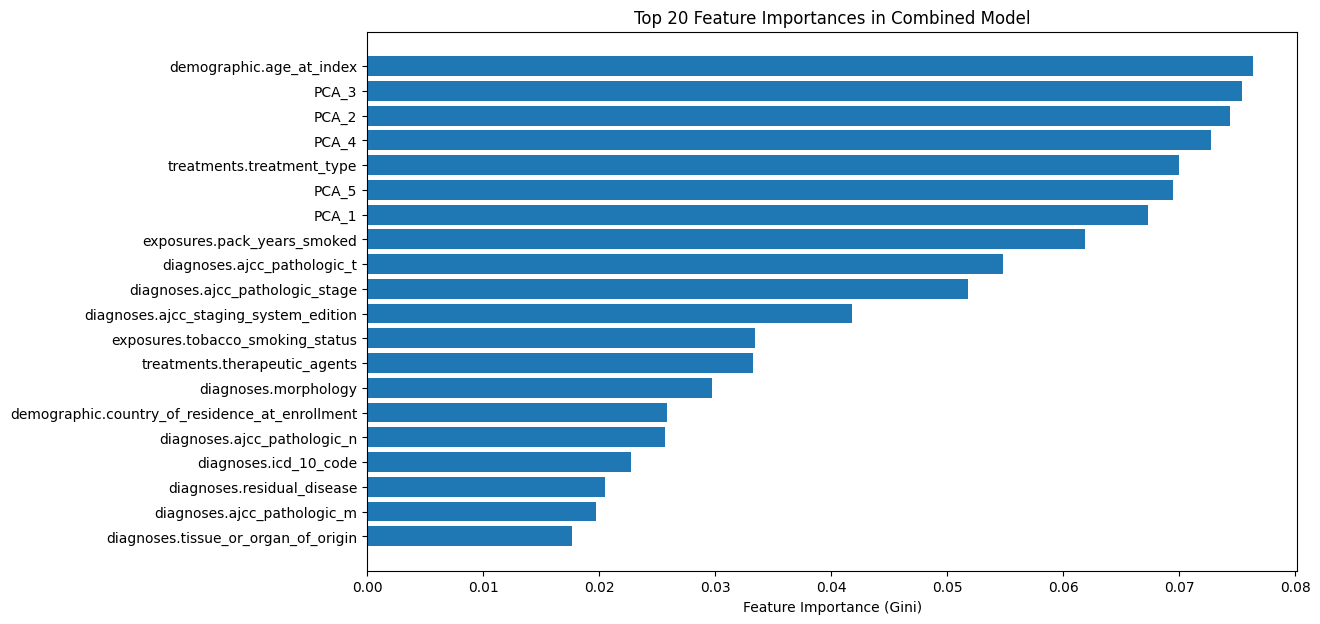


--- Feature Importance Summary ---
Top 10 Features:
                            Feature  Importance
6          demographic.age_at_index    0.076340
2                             PCA_3    0.075409
1                             PCA_2    0.074372
3                             PCA_4    0.072734
21        treatments.treatment_type    0.070018
4                             PCA_5    0.069492
0                             PCA_1    0.067348
22      exposures.pack_years_smoked    0.061896
12      diagnoses.ajcc_pathologic_t    0.054776
11  diagnoses.ajcc_pathologic_stage    0.051752


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# --- 1. Ensure Combined Data (X_combined) is Ready ---
# NOTE: You must re-run the ColumnTransformer cell (Cell 21) using the
# best 'n_components' you found (e.g., 44) to ensure X_combined is properly updated.

# --- 2. Train the Final Model on the Full Combined Dataset ---
final_model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    class_weight='balanced', 
    n_jobs=-1
)
final_model.fit(X_combined, y)

# --- 3. Create Feature Names for the Combined Data ---
# The features are ordered as: [PCA Components] then [Scaled Structured Features]
num_pca_components = X_combined.shape[1] - len(data_cols) # Get the current PCA count
pca_feature_names = [f'PCA_{i+1}' for i in range(num_pca_components)]
all_feature_names = pca_feature_names + data_cols

# --- 4. Get and Sort Feature Importances ---
importances = final_model.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)


# --- 5. Plot the Top 20 Features ---
top_n = 20
plt.figure(figsize=(12, 7))
plt.barh(feature_importances_df['Feature'].head(top_n), feature_importances_df['Importance'].head(top_n))
plt.xlabel('Feature Importance (Gini)')
plt.title(f'Top {top_n} Feature Importances in Combined Model')
plt.gca().invert_yaxis() 
plt.show()

print("\n--- Feature Importance Summary ---")
print(f"Top 10 Features:")
print(feature_importances_df.head(10))

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

# --- Step 1: Feature Selection based on Importance ---

# Set a threshold for feature selection. 
# This is a hyperparameter and should be tuned, but we start by keeping the top 20
# or all features above a small Gini importance value.
# Let's keep all features with Gini Importance > 0.005.
IMPORTANCE_THRESHOLD = 0.005 

# Filter the feature importance DataFrame (created in the previous step)
important_features_df = feature_importances_df[feature_importances_df['Importance'] >= IMPORTANCE_THRESHOLD]
FINAL_FEATURE_LIST = important_features_df['Feature'].tolist()

# Separate the final list back into structured and PCA components
final_pca_features = [f for f in FINAL_FEATURE_LIST if f.startswith('PCA_')]
final_structured_features = [f for f in FINAL_FEATURE_LIST if not f.startswith('PCA_')]

# Convert PCA feature names back to their original column indices (e.g., PCA_1 -> index 0)
# Note: We assume the PCA components are ordered 1 to N in X_combined.
# If PCA_1 is selected, we keep the first column of the PCA block, and so on.
final_pca_indices = [int(f.split('_')[1]) - 1 for f in final_pca_features] 

# --- Step 2: Create the Final Pruned Feature Matrix ---

# X_combined has [PCA Components | Structured Features]
# Find the start index of the structured features in X_combined
structured_start_index = len(pca_feature_names) 

# Map original feature names (data_cols) to their column indices in the structured block
structured_name_to_index = {name: i for i, name in enumerate(data_cols)}

# Map final structured features to their absolute column indices in X_combined
final_structured_indices = [
    structured_start_index + structured_name_to_index[name] 
    for name in final_structured_features
]

# Combine all indices and sort them
all_final_indices = sorted(final_pca_indices + final_structured_indices)

# Select the final, pruned features
X_pruned = X_combined[:, all_final_indices]


# --- Step 3: Final Cross-Validation on the Pruned Set ---
print("\n--- FINAL SCENARIO: Pruned Combined Data ---")
print(f"Features selected based on Importance > {IMPORTANCE_THRESHOLD}: {len(all_final_indices)}")
print(f"   PCA Components Kept: {len(final_pca_features)}")
print(f"   Structured Features Kept: {len(final_structured_features)}")

model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    class_weight='balanced', 
    n_jobs=-1
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = 'roc_auc'

cv_scores_pruned = cross_val_score(
    estimator=model, 
    X=X_pruned, 
    y=y, 
    cv=skf,             
    scoring=scoring,    
    n_jobs=-1           
)

print(f"\nMean CV Score (Pruned Combined): {cv_scores_pruned.mean():.4f}")
print(f"Structured Only AUC Baseline: {cv_scores_structured.mean():.4f}")


--- FINAL SCENARIO: Pruned Combined Data ---
Features selected based on Importance > 0.005: 24
   PCA Components Kept: 5
   Structured Features Kept: 19

Mean CV Score (Pruned Combined): 0.6922
Structured Only AUC Baseline: 0.6964


In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

print("\n--- FINAL STEP: GRID SEARCH TUNING (Structured Data Only) ---")

# Define the model for the Grid Search
gscv_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define the hyperparameters grid
param_grid = {
    'n_estimators': [100, 200],  # Try 100 and 200 trees
    'max_depth': [5, 10, None],  # Try shallow, moderate, and full depth
    'min_samples_split': [2, 5], # Try default and slightly higher split requirements
    'max_features': ['sqrt', 'log2'] # Try different feature subsets
}

# Use Stratified 5-Fold Cross-Validation for the search
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up the Grid Search
grid_search = GridSearchCV(
    estimator=gscv_model,
    param_grid=param_grid,
    scoring='roc_auc',  # Use AUC as the evaluation metric
    cv=skf,
    verbose=2,
    n_jobs=-1
)

# You must re-run the cell that defines X_structured_only before this step!
print("Starting GridSearchCV...")
grid_search.fit(X_structured_only, y)

# Output the best result
best_params = grid_search.best_params_
best_auc_final = grid_search.best_score_

print("\n--- FINAL MODEL PERFORMANCE (Structured Data Only) ---")
print(f"Best Hyperparameters: {best_params}")
print(f"Final Tuned Mean ROC AUC: {best_auc_final:.4f}")


--- FINAL STEP: GRID SEARCH TUNING (Structured Data Only) ---
Starting GridSearchCV...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_split